In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# pip install keras-tuner

In [2]:
import tensorflow 
import keras 
from keras.layers import Dense,Flatten
from keras.models import Model,Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt 
from keras.layers import Dense, Dropout, BatchNormalization, Input 
from keras.applications import ResNet50
from keras.applications import VGG16,VGG19,EfficientNetB3,InceptionV3
from keras.applications.efficientnet import EfficientNetB7
from keras.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger,TensorBoard 
import keras_tuner as kt 
from keras.models import load_model

2024-02-07 13:18:43.779523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 13:18:43.779633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 13:18:43.911172: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Checking for the Shape of an image
import cv2
img=cv2.imread('/kaggle/input/tomatoleaf/tomato/train/Tomato___Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG')
img.shape

(256, 256, 3)

In [4]:
train = ImageDataGenerator(rotation_range=90,horizontal_flip = True, vertical_flip =True, rescale = 1./255, shear_range = 0.2,
                                   zoom_range = 0.2)
valid = ImageDataGenerator(rescale = 1./255)

test = ImageDataGenerator(rescale = 1./255)

In [5]:
training = train.flow_from_directory('/kaggle/input/tomatoleaf/tomato/train', target_size = (256,256),class_mode = 'sparse',batch_size=64)
validation = valid.flow_from_directory('/kaggle/input/tomatoleaf/tomato/val',target_size = (256,256),class_mode = 'sparse',batch_size = 64)
testing = test.flow_from_directory('/kaggle/input/tomato-leaf-disease/tomato_dataset/test', target_size = (256,256),class_mode = 'sparse',batch_size= 64)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [6]:
# from keras.applications.efficientnet import EfficientNetB7
# #CNN Architecture
# efficient = EfficientNetB7(
#     weights='imagenet',
#     input_shape=(256,256,3),include_top=False)

In [7]:
#CNN Architecture
vgg = VGG16(
    weights='imagenet',
    input_shape=(256,256,3),include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


In [8]:
# #CNN Architecture
# inception = InceptionV3(
#     weights='imagenet',
#     input_shape=(256,256,3),include_top=False)

In [9]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [10]:
vgg.trainable=False
for i in vgg.layers:
    if i.name.startswith("block1_"): #| i.name.startswith("block2"):
        i.trainable=False
    else:
        i.trainable=True
for i in vgg.layers:
    print(i.name, i.trainable)

input_1 True
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [11]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(256,256,3)))
    
    model.add(vgg)
    model.add(Flatten())

    # Tune the number of units in the dense layer
    model.add(Dense(units=hp.Int("dense_units", min_value=256, max_value=512),
                    activation=hp.Choice("activation",values=["relu","tanh","sigmoid"]),
                    kernel_initializer=hp.Choice("weight_init",values=["glorot_uniform","glorot_normal","he_uniform","he_normal"])))
     # Add BatchNormalization
    model.add(BatchNormalization())

    # Add Dropout
    model.add(Dropout(rate=hp.Float("dropout_rate", min_value=0.1, max_value=0.3, step=0.1)))
    
   # activation_choice=hp.Choice('activation',values=['tanh','softmax','relu'])
    
    model.add(Dense(1, activation="softmax"))

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'adam', 'rmsprop', 'adadelta'])
    
    loss_function = hp.Choice('loss',values=["CategoricalCrossentropy"])

    model.compile(loss=loss_function, optimizer=optimizer_choice, metrics=['accuracy'])
    return model


In [12]:
tuner = kt.RandomSearch(build_model, objective="val_accuracy", max_trials=20,directory=r"keras_models")

tuner.search(training, epochs=2, validation_data=validation)

Trial 20 Complete [00h 04m 56s]
val_accuracy: 0.10000000149011612

Best val_accuracy So Far: 0.10000000149011612
Total elapsed time: 01h 40m 11s


In [13]:
 tuner.search_space_summary()

Search space summary
Default search space size: 6
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
weight_init (Choice)
{'default': 'glorot_uniform', 'conditions': [], 'values': ['glorot_uniform', 'glorot_normal', 'he_uniform', 'he_normal'], 'ordered': False}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam', 'rmsprop', 'adadelta'], 'ordered': False}
loss (Choice)
{'default': 'CategoricalCrossentropy', 'conditions': [], 'values': ['CategoricalCrossentropy'], 'ordered': False}


In [14]:
tuner.results_summary()

Results summary
Results in keras_models/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
dense_units: 443
activation: tanh
weight_init: glorot_normal
dropout_rate: 0.2
optimizer: sgd
loss: CategoricalCrossentropy
Score: 0.10000000149011612

Trial 01 summary
Hyperparameters:
dense_units: 259
activation: relu
weight_init: glorot_normal
dropout_rate: 0.2
optimizer: rmsprop
loss: CategoricalCrossentropy
Score: 0.10000000149011612

Trial 02 summary
Hyperparameters:
dense_units: 390
activation: tanh
weight_init: he_uniform
dropout_rate: 0.2
optimizer: sgd
loss: CategoricalCrossentropy
Score: 0.10000000149011612

Trial 03 summary
Hyperparameters:
dense_units: 420
activation: relu
weight_init: he_uniform
dropout_rate: 0.2
optimizer: rmsprop
loss: CategoricalCrossentropy
Score: 0.10000000149011612

Trial 04 summary
Hyperparameters:
dense_units: 404
activation: tanh
weight_init: glorot_uniform
dropout_rate: 0.2
optimizer: 

In [15]:
tuner.get_best_hyperparameters()[0].values

{'dense_units': 443,
 'activation': 'tanh',
 'weight_init': 'glorot_normal',
 'dropout_rate': 0.2,
 'optimizer': 'sgd',
 'loss': 'CategoricalCrossentropy'}

In [16]:
fmodel = tuner.get_best_models(num_models = 1)[0]
fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 443)               14516667  
                                                                 
 batch_normalization (Batch  (None, 443)               1772      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 443)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 444       
                                                        

In [17]:
es=EarlyStopping(monitor="val_loss",min_delta=0.1,patience=2,start_from_epoch=4,verbose=1) 

mc=ModelCheckpoint(r"model_checkpoint\model{epoch}.h5",monitor='val_loss',verbose=1,save_best_only=True)

In [18]:
csv=CSVLogger(r"log.csv")

In [25]:
his = fmodel.fit_generator(training,steps_per_epoch = 18345 //64, epochs = 5,validation_data = validation , validation_steps = 4585//64 , callbacks = [ mc, csv])

/tmp/ipykernel_34/2562181956.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = fmodel.fit_generator(training,steps_per_epoch = 18345 //64, epochs = 5,validation_data = validation , validation_steps = 4585//64 , callbacks = [ mc, csv])


Epoch 1/5
157/286 [===============>..............] - ETA: 2:03 - loss: 0.0000e+00 - accuracy: 0.1000
Epoch 1: val_loss did not improve from 0.00000
286/286 [==============================] - 155s 541ms/step - loss: 0.0000e+00 - accuracy: 0.1000 - val_loss: 0.0000e+00 - val_accuracy: 0.1000


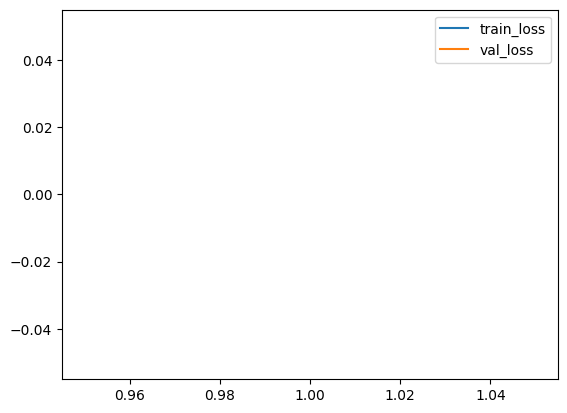

In [26]:
plt.plot(range(1,2),his.history["loss"],label="train_loss")
plt.plot(range(1,2),his.history["val_loss"],label="val_loss")
plt.legend()

In [27]:
fmodel.save('best_model',save_format = 'h5')

# Read model
m1 = load_model(r'/kaggle/working/best_model') 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
prediction = fmodel.predict(testing)

1/1 [==============================] - 0s 254ms/step


In [29]:
import numpy as np 
predicted=np.where(prediction>0.5,1,0)

accuracy_score :  0.1


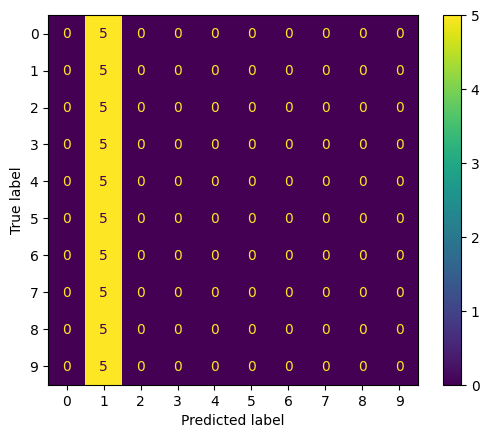

In [30]:
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix
print("accuracy_score : ",accuracy_score(testing.labels,predicted)) 
cm=confusion_matrix(testing.labels,predicted)
va=ConfusionMatrixDisplay(cm)
va.plot() 
plt.show() 